In [2]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [1]:
!pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 4.7 MB/s eta 0:00:00a 0:00:01m
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Specify each path

In [19]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [25]:
NUM_CLASSES = 8

# Dataset reading

In [97]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_dataset.shape

(8874, 42)

In [98]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
y_dataset.shape

(8874,)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [101]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Input(shape=(42,)),  # 21 landmarks × x,y
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [102]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,072 (125.28 KB)

 Trainable params: 31,432 (122.78 KB)

 Non-trainable params: 640 (2.50 KB)

In [103]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=40, verbose=1)

In [104]:
# Load gesture labels and create a complete hand gesture detector
import csv
import os

def load_labels(label_path):
    with open(label_path, encoding='utf-8-sig') as f:
        labels = csv.reader(f)
        labels = [row[0] for row in labels]
    return labels

# Load the gesture labels
hand_gesture_path = ""
label_path = os.path.join(hand_gesture_path, 'model/keypoint_classifier/keypoint_classifier_label.csv')
gesture_labels = load_labels(label_path)

print("Available gestures:", gesture_labels)

# Map the model's gestures to your game actions
MODEL_TO_GAME_GESTURE_MAP = {
    'Open': 'open_palm',
    'Close': 'fist', 
    'Pointer': 'one_finger_point',
    'OK': 'ok'
}

def classify_gesture(landmark_list):
    """
    Classify hand gesture from landmark list
    landmark_list: normalized landmark coordinates (21 points * 2 coordinates = 42 values)
    """
    gesture_id = keypoint_classifier(landmark_list)
    gesture_name = gesture_labels[gesture_id]
    game_gesture = MODEL_TO_GAME_GESTURE_MAP.get(gesture_name, 'unknown')
    return gesture_name, game_gesture

print("Gesture classifier setup complete!")


Available gestures: ['Open', 'Close', 'One', 'OK', 'Pinch', 'Two', 'Three', 'Four']
Gesture classifier setup complete!


In [105]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [106]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2788 - loss: 2.4282
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3258 - loss: 2.2869 - val_accuracy: 0.5949 - val_loss: 1.8909
Epoch 2/1000
40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7345 - loss: 1.0953
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7427 - loss: 1.0703 - val_accuracy: 0.6580 - val_loss: 1.6451
Epoch 3/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8411 - loss: 0.7820
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8412 - loss: 0.7814 - val_accuracy: 0.6507 - val_loss: 1.4628
Epoch 4/1000
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8778 - loss: 0.6632
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/

In [107]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9861 - loss: 0.1307 


In [108]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [109]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
[1.5660289e-07 3.2982084e-06 4.6129417e-06 1.2158740e-06 1.2317237e-05
 9.9826694e-01 1.7079986e-03 3.3834465e-06]
5


# Confusion matrix

In [110]:
!pip install pandas seaborn matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


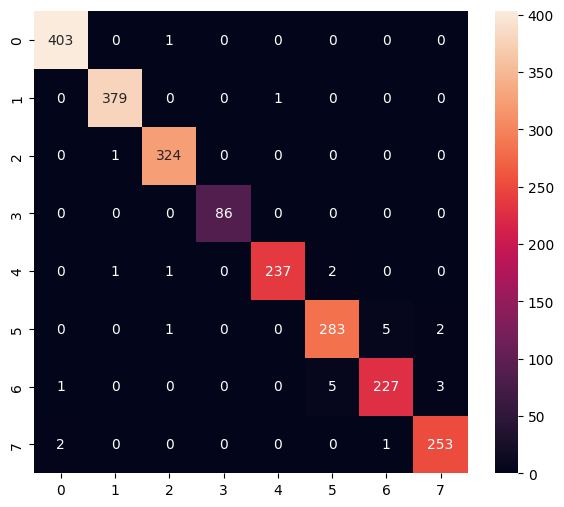

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       404
           1       0.99      1.00      1.00       380
           2       0.99      1.00      0.99       325
           3       1.00      1.00      1.00        86
           4       1.00      0.98      0.99       241
           5       0.98      0.97      0.97       291
           6       0.97      0.96      0.97       236
           7       0.98      0.99      0.98       256

    accuracy                           0.99      2219
   macro avg       0.99      0.99      0.99      2219
weighted avg       0.99      0.99      0.99      2219



In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [112]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [113]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enable TensorFlow ops and disable experimental tensor list lowering
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

converter._experimental_lower_tensor_list_ops = False
tflite_quantized_model = converter.convert()


open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/h8/7g6ps5r13vn_sdc7z1081w480000gr/T/tmpm82p01qs/assets


INFO:tensorflow:Assets written to: /var/folders/h8/7g6ps5r13vn_sdc7z1081w480000gr/T/tmpm82p01qs/assets


Saved artifact at '/var/folders/h8/7g6ps5r13vn_sdc7z1081w480000gr/T/tmpm82p01qs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_11')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  15456965392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15456960784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15456966928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15456960976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15456968080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15456961168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15456961360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15456972688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14221047184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14221047952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15456962128: Tens

W0000 00:00:1753105705.258159 34673502 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1753105705.258327 34673502 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


40112

# Inference test

In [114]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

/Users/marcolee/Desktop/pathpulse/projects/venv/lib/python3.11/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [115]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [116]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [117]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 479 μs, sys: 1.12 ms, total: 1.59 ms
Wall time: 1.08 ms


In [118]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.6578599e-07 3.5660830e-06 4.7386457e-06 1.2274836e-06 1.2485729e-05
 9.9823511e-01 1.7393538e-03 3.4246314e-06]
5
